In [ ]:
import torch
print('PyTorch version:', torch.__version__)
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
print('Torchvision version:', torchvision.__version__)
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


#  Define the device

In [ ]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

GPU name: Tesla T4 

Device is: cuda 

Total number of GPUs: 1


# **Load MNIST Dataset**
The MNIST dataset is a popular collection of handwritten digits widely used in machine learning and image processing. It contains a large number of images of digits (from 0 to 9) written by different people. The dataset is separated into a training set of 60,000 examples and a test set of 10,000 examples, making it ideal for training and evaluating machine learning models for tasks like digit recognition.

When using U-Net to process 28x28 images from MNIST, the image size will reduce down to 3.5x3.5 after 4 rounds of downsampling. By simply taking the integer part, the image size would be 3x3, leading to the loss of significant information from the image.
A solution to this issue would be to resize the input image to 32x32.

In [ ]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [ ]:
training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32617968.91it/s]


Extracting ./data_src/MNIST/raw/train-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1384581.99it/s]


Extracting ./data_src/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 7988360.79it/s]


Extracting ./data_src/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_src/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10127872.82it/s]

Extracting ./data_src/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_src/MNIST/raw



Visualize the Training Dataset

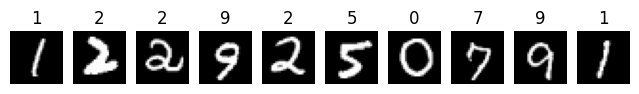

In [ ]:
# show 10 randomly selected samples from the training dataset
fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

Visualize the Test Dataset

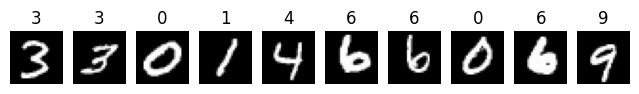

In [ ]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False);

# Define dataloaders

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Define Linear_Variance_Scheduler

Implementing a DDPM model is simple. We define a model that takes
two inputs: Images and the randomly sampled time steps. At each training step, we
perform the following operations to train our model:

1. Sample random noise to be added to the inputs.
2. Apply the forward process to diffuse the inputs with the sampled noise.
3. Your model takes these noisy samples as inputs and outputs the noise
prediction for each time step.
4. Given true noise and predicted noise, we calculate the loss values
5. We then calculate the gradients and update the model weights.
![Ảnh](https://drive.google.com/uc?export=view&id=1lwPwoCQP87mSuzaFNUU-LTHruPb8eosS)

In [ ]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):

        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def diffusion_process(self, x, noise, t):
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# Forward process output

In [ ]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [ ]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

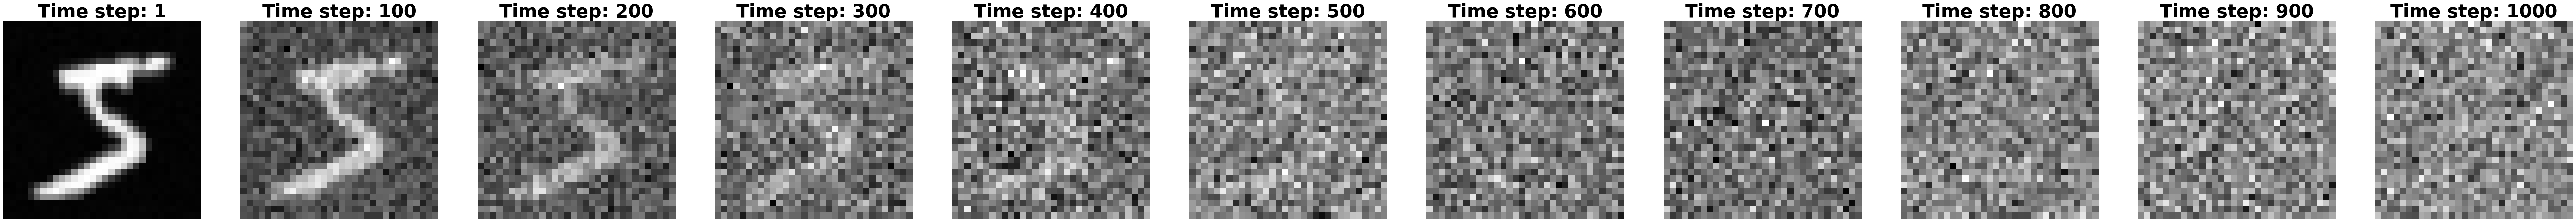

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False);

# Unet Network
U-Net, originally developed for semantic segmentation, is an architecture that is
widely used for implementing diffusion models but with some slight modifications:

1. The network accepts two inputs: Image and time step
2. Self-attention between the convolution blocks once we reach a specific resolution
(16x16 in the paper)
3. Group Normalization instead of weight normalization


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()

        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))

    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

In [ ]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()

        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)

    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()

        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )

        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

In [ ]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()

        self.device = device
        self.t_emb_dim = t_emb_dim

        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [ ]:
summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [64, 1, 32, 32]           --
├─ResBlock: 1-1                               [64, 64, 32, 32]          --
│    └─Sequential: 2-1                        [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                       [64, 64, 32, 32]          640
│    │    └─GroupNorm: 3-2                    [64, 64, 32, 32]          128
│    │    └─SiLU: 3-3                         [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                       [64, 64, 32, 32]          36,928
│    │    └─GroupNorm: 3-5                    [64, 64, 32, 32]          128
├─DownBlock: 1-2                              [64, 128, 16, 16]         --
│    └─Sequential: 2-2                        [64, 128, 16, 16]         --
│    │    └─MaxPool2d: 3-6                    [64, 64, 16, 16]          --
│    │    └─ResBlock: 3-7                     [64, 64, 16, 16]          74,112
│    │   

# Set up Linear_Variance_Scheduler, model (UNet), criterion (loss_function) and optimizer

In [ ]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [ ]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 25
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []

    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()

    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 156/156 [00:16<00:00,  9.54it/s]


Epoch: 1/25	| Training loss: 0.0661 |   Test loss: 0.0314


100%|██████████| 156/156 [00:16<00:00,  9.73it/s]


Epoch: 2/25	| Training loss: 0.0284 |   Test loss: 0.0262


100%|██████████| 156/156 [00:16<00:00,  9.64it/s]


Epoch: 3/25	| Training loss: 0.0242 |   Test loss: 0.0233


100%|██████████| 156/156 [00:16<00:00,  9.75it/s]


Epoch: 4/25	| Training loss: 0.0220 |   Test loss: 0.0206


100%|██████████| 156/156 [00:16<00:00,  9.65it/s]


Epoch: 5/25	| Training loss: 0.0206 |   Test loss: 0.0203


100%|██████████| 156/156 [00:15<00:00,  9.81it/s]


Epoch: 6/25	| Training loss: 0.0195 |   Test loss: 0.0206


100%|██████████| 156/156 [00:16<00:00,  9.61it/s]


Epoch: 7/25	| Training loss: 0.0190 |   Test loss: 0.0184


100%|██████████| 156/156 [00:16<00:00,  9.49it/s]


Epoch: 8/25	| Training loss: 0.0183 |   Test loss: 0.0178


100%|██████████| 156/156 [00:15<00:00,  9.78it/s]


Epoch: 9/25	| Training loss: 0.0180 |   Test loss: 0.0184


100%|██████████| 156/156 [00:15<00:00,  9.82it/s]


Epoch: 10/25	| Training loss: 0.0175 |   Test loss: 0.0176


100%|██████████| 156/156 [00:15<00:00,  9.80it/s]


Epoch: 11/25	| Training loss: 0.0176 |   Test loss: 0.0179


100%|██████████| 156/156 [00:16<00:00,  9.67it/s]


Epoch: 12/25	| Training loss: 0.0172 |   Test loss: 0.0169


100%|██████████| 156/156 [00:15<00:00,  9.81it/s]


Epoch: 13/25	| Training loss: 0.0169 |   Test loss: 0.0163


100%|██████████| 156/156 [00:15<00:00,  9.76it/s]


Epoch: 14/25	| Training loss: 0.0166 |   Test loss: 0.0164


100%|██████████| 156/156 [00:16<00:00,  9.55it/s]


Epoch: 15/25	| Training loss: 0.0168 |   Test loss: 0.0169


100%|██████████| 156/156 [00:16<00:00,  9.65it/s]


Epoch: 16/25	| Training loss: 0.0164 |   Test loss: 0.0168


100%|██████████| 156/156 [00:16<00:00,  9.73it/s]


Epoch: 17/25	| Training loss: 0.0161 |   Test loss: 0.0162


100%|██████████| 156/156 [00:16<00:00,  9.68it/s]


Epoch: 18/25	| Training loss: 0.0163 |   Test loss: 0.0160


100%|██████████| 156/156 [00:16<00:00,  9.68it/s]


Epoch: 19/25	| Training loss: 0.0163 |   Test loss: 0.0155


100%|██████████| 156/156 [00:15<00:00,  9.77it/s]


Epoch: 20/25	| Training loss: 0.0158 |   Test loss: 0.0160


100%|██████████| 156/156 [00:15<00:00,  9.75it/s]


Epoch: 21/25	| Training loss: 0.0158 |   Test loss: 0.0161


100%|██████████| 156/156 [00:15<00:00,  9.75it/s]


Epoch: 22/25	| Training loss: 0.0159 |   Test loss: 0.0159


100%|██████████| 156/156 [00:15<00:00,  9.75it/s]


Epoch: 23/25	| Training loss: 0.0157 |   Test loss: 0.0163


100%|██████████| 156/156 [00:16<00:00,  9.74it/s]


Epoch: 24/25	| Training loss: 0.0159 |   Test loss: 0.0152


100%|██████████| 156/156 [00:15<00:00,  9.77it/s]

Epoch: 25/25	| Training loss: 0.0156 |   Test loss: 0.0157


# Plot Losses

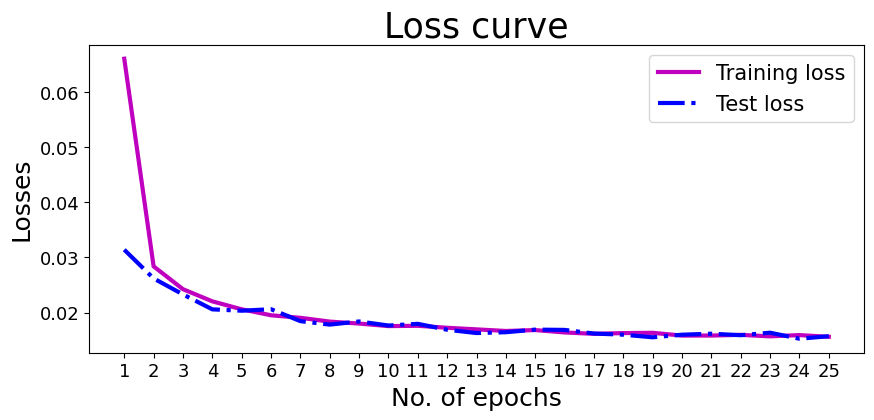

In [ ]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15);

# Reverse process output

In [ ]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)

1000it [00:09, 110.61it/s]


In [ ]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]

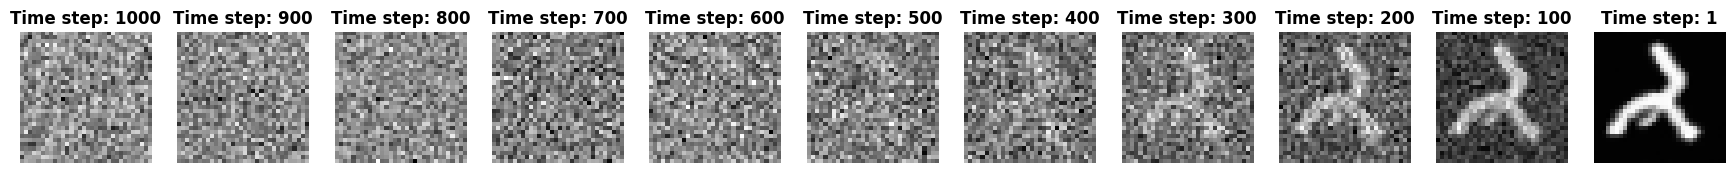

In [ ]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1;

# Random sampling from noise

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)

1000it [01:23, 11.96it/s]


In [ ]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)

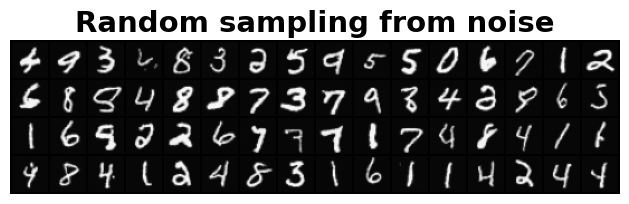

In [ ]:
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)
plt.title('Random sampling from noise', fontsize=21, fontweight='bold');